You will have to restart twice during module install on colab. I need to install downgrade Torch version to ensure compatability. **Make sure to select T4 GPU under Resource.**

In [6]:
import torch
if torch.__version__ != '2.5.1+cu121':
    !pip install ipython==8.1.0
    !pip uninstall torch torch-scatter torch-sparse torch-geometric torch-cluster  --y
    !pip install torch==2.5.1 torchvision==0.20.1 torchaudio==2.5.1 --index-url https://download.pytorch.org/whl/cu121
try:
    from becqsdr.data import train_valid_test_split
except ModuleNotFoundError:
    !pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
    !pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
    !pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
    !pip install e3nn
    !pip install torch-geometric -f https://data.pyg.org/whl/torch-{torch.__version__}.html
    !git clone https://github.com/jingsk/BEC_QSPR.git
    %cd /content/BEC_QSPR
    !pip install .
try:
    import cmcrameri.cm as cm
except ModuleNotFoundError:
    !pip install cmcrameri

try:
    from ase import Atom, Atoms
except ModuleNotFoundError:
    !pip install ase
!pip install imp


ERROR: Could not find a version that satisfies the requirement imp (from versions: none)
ERROR: No matching distribution found for imp


In [1]:
# model
import torch
#import torch.nn as nn
#import torch.nn.functional as F
import torch_geometric as tg
#import torch_scatter
import e3nn
from e3nn import o3
from e3nn.io import CartesianTensor
from e3nn.o3 import ReducedTensorProducts
from typing import Dict, Union
from becqsdr.data import train_valid_test_split
#from utils.e3nn import Network
from becqsdr.model import E3NN

import cmcrameri.cm as cm

# crystal structure data
from ase import Atom, Atoms
from ase.neighborlist import neighbor_list
from ase.visualize.plot import plot_atoms

# data pre-processing and visualization
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

%load_ext autoreload
%autoreload 2

# utilities
from tqdm import tqdm
from becqsdr.data import load_db


import warnings
warnings.filterwarnings("ignore")

bar_format = '{l_bar}{bar:10}{r_bar}{bar:-10b}'
tqdm.pandas(bar_format=bar_format)
default_dtype = torch.float64
torch.set_default_dtype(default_dtype)
device = "cuda"

r_max = 3.5 # cutoff radius

In [3]:
# load data
df, species = load_db('BEC_QSPR/data/bec_run.db', selection='gap>0,converged=True')
species = [Atom(k).number for k in species]
Z_max = max([Atom(k).number for k in species])

# one-hot encoding atom type and mass
type_encoding = {}
specie_am = []
for Z in tqdm(range(1, Z_max+1), bar_format=bar_format):
    specie = Atom(Z)
    type_encoding[specie.symbol] = Z - 1
    specie_am.append(specie.mass)

type_onehot = torch.eye(len(type_encoding))
am_onehot = torch.diag(torch.tensor(specie_am))

100%|██████████| 60/60 [00:00<00:00, 217133.94it/s]


In [4]:
# build data
def build_data(entry, type_encoding, type_onehot, r_max=3.5):

    symbols = list(entry.structure.symbols).copy()
    positions = torch.from_numpy(entry.structure.positions.copy())
    lattice = torch.from_numpy(entry.structure.cell.array.copy()).unsqueeze(0)

    # edge_src and edge_dst are the indices of the central and neighboring atom, respectively
    # edge_shift indicates whether the neighbors are in different images or copies of the unit cell
    edge_src, edge_dst, edge_shift = neighbor_list("ijS", a=entry.structure, cutoff=r_max, self_interaction=True)

    # compute the relative distances and unit cell shifts from periodic boundaries
    edge_batch = positions.new_zeros(positions.shape[0], dtype=torch.long)[torch.from_numpy(edge_src)]
    edge_vec = (positions[torch.from_numpy(edge_dst)]
                - positions[torch.from_numpy(edge_src)]
                + torch.einsum('ni,nij->nj', torch.tensor(edge_shift, dtype=default_dtype), lattice[edge_batch]))

    # compute edge lengths (rounded only for plotting purposes)
    edge_len = np.around(edge_vec.norm(dim=1).numpy(), decimals=2)

    data = tg.data.Data(
        pos=positions, lattice=lattice, symbol=symbols,
        x_in=am_onehot[[type_encoding[specie] for specie in symbols]],   # atomic mass (node feature)
        z_in=type_onehot[[type_encoding[specie] for specie in symbols]], # atom type (node attribute)
        edge_index=torch.stack([torch.LongTensor(edge_src), torch.LongTensor(edge_dst)], dim=0),
        edge_shift=torch.tensor(edge_shift, dtype=default_dtype),
        edge_vec=edge_vec, edge_len=edge_len,
        y=CartesianTensor("ij=ji").from_cartesian(torch.from_numpy(entry.diel), rtp=ReducedTensorProducts('ij=ji', i='1o')).unsqueeze(0),
        b=CartesianTensor("ij=ij").from_cartesian(torch.from_numpy(entry.bec)).unsqueeze(0)
    )

    return data


df['data'] = df.progress_apply(lambda x: build_data(x, type_encoding, type_onehot, r_max), axis=1)

100%|██████████| 183/183 [02:23<00:00,  1.27it/s]


In [5]:
# Train/valid/test split
valid_size = 0.1
test_size = 0.1
idx_train, idx_valid, idx_test = train_valid_test_split(df.data, valid_size=valid_size, test_size=test_size)
# Format dataloaders
batch_size = 4
dataloader_train = tg.loader.DataLoader(df.iloc[idx_train]['data'].tolist(), batch_size=batch_size, shuffle=True)
dataloader_valid = tg.loader.DataLoader(df.iloc[idx_valid]['data'].tolist(), batch_size=batch_size)
dataloader_test = tg.loader.DataLoader(df.iloc[idx_test]['data'].tolist(), batch_size=batch_size)

In [9]:
#Z_max = 4
args_enn = {'in_dim': Z_max,
            'emb_dim': 4,
            'num_layers': 2,
            'max_radius': r_max,
            'num_neighbors': 10,
           }

enn = E3NN(**args_enn).to(device)
opt = torch.optim.Adam(enn.parameters(), lr=1e-3)
scheduler = None #torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.99)

!mkdir -p models
model_path = 'models/' + enn.model_name + '.torch'


In [10]:
resume = False
max_iter = 40

if resume:
    saved = torch.load(model_path, map_location=device)
    enn.load_state_dict(saved['state'])
    opt.load_state_dict(saved['optimizer'])
    try:
        scheduler.load_state_dict(saved['scheduler'])
    except:
        scheduler = None
    history = saved['history']
    s0 = history[-1]['step'] + 1
    print(f'loading from {model_path}')
    print(f'Starting from step {s0:d}/{max_iter:d}')

else:
    history = []
    s0 = 0

# fit E3NN
for results in enn.fit(opt, dataloader_train, dataloader_valid, history, s0, max_iter=max(0,max_iter-s0), device=device,
                       scheduler=scheduler):
    with open(model_path, 'wb') as f:
        torch.save(results, f)

Iteration    10    batch    37 /    37   epoch loss = 1.4022e-02, bec. = 1.4022e-02
Iteration    20    batch    37 /    37   epoch loss = 7.3089e-03, bec. = 7.3089e-03
Iteration    30    batch    37 /    37   epoch loss = 4.3228e-03, bec. = 4.3228e-03
Iteration    40    batch    37 /    37   epoch loss = 3.1251e-03, bec. = 3.1251e-03


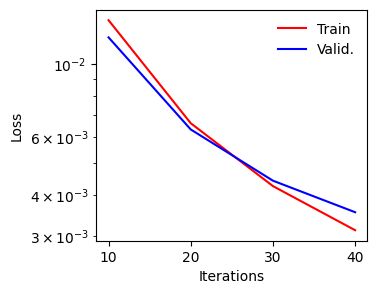

In [15]:
saved = torch.load(model_path, map_location=device)
history = saved['history']

steps = [d['step'] + 1 for d in history]
loss_train = [d['train']['loss'] for d in history]
loss_valid = [d['valid']['loss'] for d in history]

fig, ax = plt.subplots(figsize=(3.5,3))
ax.plot(steps, loss_train, label='Train', color='red')
ax.plot(steps, loss_valid, label='Valid.', color='blue')
ax.set_xlabel('Iterations')
ax.set_ylabel('Loss')
ax.legend(frameon=False)
ax.set_yscale('log')
!mkdir -p images
fig.savefig('images/loss.png', dpi=300, bbox_inches='tight')

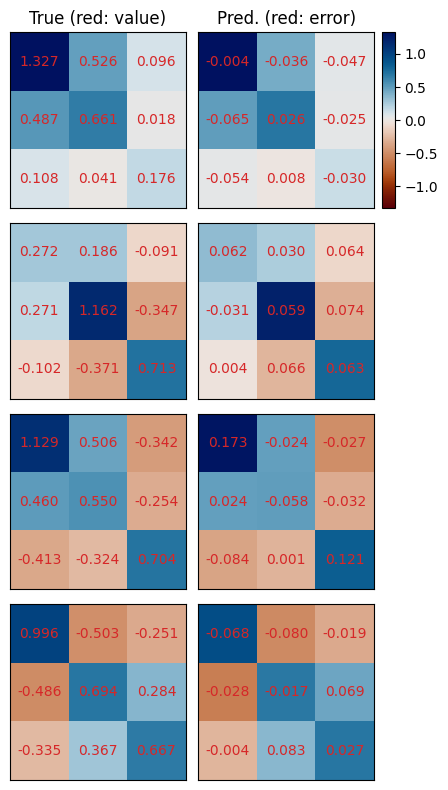

In [16]:
from becqsdr.model import visualize_output

enn.load_state_dict(saved['state'])
entry = df.iloc[idx_test].iloc[0]
visualize_output(entry, enn, device)